The Basic RRT Algorithm (Parallelized NN & CC)
--

In [7]:
import math
import numpy as np
from numba import cuda
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [8]:
TPB = 16 # number of threads in a block

# device function_NN
"""Calculates the nearest neighbor"""
@cuda.jit(device=True)
def euc_distance_2d_device(x1,y1,x2,y2):
    """Calculates the eucledian distance between given points"""
    d = math.sqrt((x2-x1)**2+(y2-y1)**2)
    return d

@cuda.jit()
def distanceKernel(d_out,x,y,d_V,nov):
    """NN Array"""
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    if i < nov:
        d_out[i] = euc_distance_2d_device(x,y,d_V[0,i],d_V[1,i])

# wrapper function_NN
def dArray(x,y,V,nov):
    d_V = cuda.to_device(V) # copies the input data to a device array on the GPU, array of column vectors
    dummy = np.zeros(nov)
    d_distance = cuda.to_device(dummy) # creates an empty array to hold the output
    BPG = (nov + TPB - 1)//TPB # computes number of blocks
    distanceKernel[BPG,TPB](d_distance,x,y,d_V,nov)
    return d_distance.copy_to_host()

In [9]:
# device function_CC, doesn't stop kernel after collision, finding break required
@cuda.jit(device=True)
def cc_dev(x1,y1,x2,y2,allowable_radius):
    #d = math.sqrt((x2-x1)**2+(y2-y1)**2)
    d = euc_distance_2d_device(x1,y1,x2,y2)
    return d>allowable_radius # should be 1 for no collision

@cuda.jit()
def ccKernel(d_out,x,y,d_O,all_radii):
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    #flag = 1
    if i < all_radii.size:# and flag ==1:
        d_out[i] = cc_dev(x,y,d_O[0,i],d_O[1,i],all_radii[i])
        # flag = d_out[i]

# wrapper function_CC
def dArray_CC(x,y,obs_coors,allowable_radii):
    noo = allowable_radii.size
    d_all_radii = cuda.to_device(allowable_radii) # copies the input data to a device array on the GPU
    d_O = cuda.to_device(obs_coors) # copies the input data to a device array on the GPU
    d_collision = cuda.device_array(noo) # creates an empty array to hold the output
    BPG = (noo + TPB - 1)//TPB # computes number of blocks
    ccKernel[BPG,TPB](d_collision,x,y,d_O,d_all_radii)
    return d_collision.copy_to_host()

In [10]:
def euc_distance_2d(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

def nearest_neighbor_2d_parallel(x,y,V,nov):
    distance = dArray(x,y,V,nov)
    ind_min = np.argmin(distance)
    min_dis = distance[ind_min]
    return [min_dis,ind_min]

def collision_check_parallel(x,y,obstacle_coordinates,obstacle_radii):
    allowable_radii = obstacle_radii*2/np.sqrt(3)
    flag = 0 # means no collision
    if all(dArray_CC(x,y,obstacle_coordinates,allowable_radii)):
        flag = 1
    return flag

def draw_circle(xc,yc,r):
    t = np.arange(0,2*np.pi,.05)
    x = xc+r*np.sin(t)
    y = yc+r*np.cos(t)
    plt.plot(x,y,c='blue')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:50<00:00, 50.30s/it]


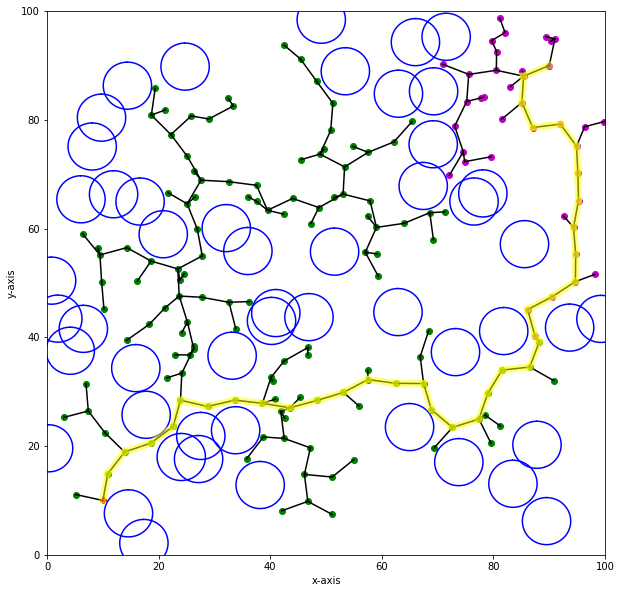

In [15]:
def main():
    max_iter = 1500
    epsilon = 5 # step size
    
    flag = 0 # for finding a connectivity path
    

    # initial and goal points/states
    x0 = 10
    y0 = 10
    x_goal = 90
    y_goal = 90
    fig, ax = plt.subplots(figsize=[10,10])
    
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    #ax.set_axis('scaled')
    
    ax.scatter([x0,x_goal],[y0,y_goal],c='r',marker="P")
    plt.savefig('base.png')

    # obstacle info
    noo = 50 # no. of obstacles
    radius = np.sqrt(3)/2*epsilon
    obs_radii = radius*np.ones(noo)
    obs_coors = 100*np.random.rand(2,noo) # position of obstacles
    for i in range(0,noo):
        draw_circle(obs_coors[0,i],obs_coors[1,i],obs_radii[i])
    plt.savefig('basewithobs.png')

    if euc_distance_2d(x0,y0,x_goal,y_goal)<epsilon:
        flag = 1
        plt.plot([x0,x_goal],[y0,y_goal],c='black')
    else:
        #xi = np.zeros(max_iter+1)
        #yi = np.zeros(max_iter+1)
        #xg = np.zeros(max_iter+1)
        #yg = np.zeros(max_iter+1)
        vertices = np.zeros([2,2,max_iter+1])
        #vertices = np.zeros([2,2,max_iter+1])
        A = -np.ones([2,(max_iter+1)//2,(max_iter+1)//2])
        #Ago = -np.ones([max_iter+1,max_iter+1])
        #xi[0] = x0;
        #yi[0] = y0;
        #xg[0] = x_goal;
        #yg[0] = y_goal;
        vertices[0,0,0] = x0
        vertices[0,1,0] = y0
        vertices[1,0,0] = x_goal
        vertices[1,1,0] = y_goal
        A[0,0,0] = 0
        A[1,0,0] = 0

    nov=np.zeros(2,dtype=np.int64) # no. of vertices except the initial one

    i = 0
    while flag==0 and i<max_iter:
        i += 1
        for k in range(2):
            #print('i=',i)
            #print('k=',k)
            if k == 0:
            #    vertices = verticesini
            #    A = Aini
            #    x_connect = verticesgo[0,nov]
            #    y_connect = verticesgo[1,nov]
                color = 'g'
            else:
            #    vertices = verticesgo
            #    A = Ago
            #    x_connect = verticesini[0,nov]
            #    y_connect = verticesini[1,nov]
                color = 'm'
            x_rand= 100*np.random.rand(1) #returns an array
            y_rand= 100*np.random.rand(1) #returns an array
            #xy_rand = np.array([x_rand,y_rand]).reshape(2,) #reshape to one 
            
            [min_dis,p_near] = nearest_neighbor_2d_parallel(x_rand[0],y_rand[0],vertices[k,:,:],nov[k]+1)
            #print(i,flag)
            if min_dis<epsilon:
                x_new = x_rand
                y_new = y_rand
            else: # interpolate
                r = epsilon/min_dis # ratio
                x_new = vertices[k,0,p_near]+r*(x_rand-vertices[k,0,p_near])
                y_new = vertices[k,1,p_near]+r*(y_rand-vertices[k,1,p_near])
            if collision_check_parallel(x_new[0],y_new[0],obs_coors,obs_radii):
                nov[k] = nov[k]+1
                vertices[k,0,nov[k]] = x_new
                vertices[k,1,nov[k]] = y_new
                ax.scatter(x_new,y_new,c=color)
                ax.plot([vertices[k,0,p_near],x_new],[vertices[k,1,p_near],y_new],c='black')
                A[k,nov[k],:] = A[k,p_near,:]
                A[k,nov[k],nov[k]] = nov[k]
                #print('xnewtype=',type(x_new))
                #print('xnew= ',x_new)
                #print('xnew0type',type(x_new[0]))
                #print('xne0=',x_new[0])
                #print(vertices[(1-k),:,:])
                min_dis_to_other_tree, ind_other_tree = nearest_neighbor_2d_parallel(x_new[0],y_new[0],vertices[(1-k),:,:],nov[1-k]+1)
                if min_dis_to_other_tree < epsilon:
                    nov[k] = nov[k]+1
                    A[k,nov[k],:] = A[k,nov[k]-1,:]
                    A[k,nov[k],nov[k]] = nov[k]
                    vertices[k,0,nov[k]] = vertices[(1-k),0,ind_other_tree]
                    vertices[k,1,nov[k]] = vertices[(1-k),1,ind_other_tree]
                    ax.plot([x_new,vertices[(1-k),0,ind_other_tree]],[y_new,vertices[(1-k),1,ind_other_tree]],c='black')
                    flag = 1
            #if k == 0:
            #   verticesini = vertices
            #    Aini = A
            #else:
            #    verticesgo = vertices
            #    Ago = A
        plt.savefig(str(i)+'.png')
            
            
                    
                
               
               
    
    
    #plt.show()

    if flag ==1 and (nov[0]!=0 or nov[1]!=0):
        for cp in range(0,2):
            B = np.zeros(nov[k])
            nov_path =0 # no. of vertices on the connectivity path
            for i in range(0,nov[k]+1):
                if A[k,nov[k],i]>-1:
                    B[nov_path]=A[k,nov[k],i]
                    nov_path += 1
            B = B[0:nov_path]
            for i in range(0, B.size-1):
                plt.plot([vertices[k,0,int(B[i])],vertices[k,0,int(B[i+1])]],[vertices[k,1,int(B[i])],vertices[k,1,int(B[i+1])]],c='yellow',linewidth=7,alpha=0.5)
            k = 1-k
            nov[k] = ind_other_tree
    elif flag ==0:
        print('No solution has been found for the given maximum number of iterations.')
    plt.savefig('CompleteMap.png')
    #print(flag)
    #print('Size of vertices matrix', vertices.size)
    #print('Size of vertices goal matrix', verticesgo.size)
    #print('Size of vertices initial matrix', verticesini.size)
    #print('Size of A matrix',A.size)
    #print('Size of Aini matrix',Aini.size)
    #print('Size of Ago matrix',Ago.size)
    
for iter in tqdm(range(1)):
    main()